<h1 style="color:green;"> Data modelling </h1>


<h3> Import necessary libraries </h3>

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


<h3> Chúng ta sẽ nhìn lại tập dữ liệu sau quá trình tiền xử lý và khai thác </h3>

In [14]:
cleaned_df = pd.read_csv('processed_data.csv')

In [15]:
cleaned_df.head(10)

,Title,withDLC,isMature,Developer,Publisher,PositiveReviews,TotalReviews,NegativeReviews,Price,ReleaseYear,...,Genre__RPG,Genre__Racing,Genre__Simulation,Genre__Software Training,Genre__Sports,Genre__Strategy,Genre__Utilities,Genre__Video Production,Genre__Web Publishing,Rating
0,Endless Monday: Dreams and Deadlines,0,0,2022,1581,737,737,0,142000.0,2023,...,0,0,0,0,0,0,0,0,0,0.931514
1,Papa's Freezeria Deluxe,0,0,592,470,6514,6562,48,87500.0,2023,...,0,0,1,0,0,1,0,0,0,0.957730
2,Cats Hidden in Jingle Jam,0,0,1819,1412,5097,5108,11,0.0,2023,...,0,0,0,0,0,0,0,0,0,0.959760
3,An Arcade Full of Cats,1,0,439,359,3018,3045,27,0.0,2023,...,0,0,0,0,0,0,0,0,0,0.947230
4,Ib,0,0,2036,1003,3068,3098,30,150000.0,2022,...,0,0,0,0,0,0,0,0,0,0.946714
5,Lil Gator Game,0,0,1074,1048,3363,3395,32,260000.0,2022,...,0,0,0,0,0,0,0,0,0,0.948134
6,星空列车与白的旅行,1,1,2076,1588,3056,3083,27,188000.0,2021,...,0,0,0,0,0,0,0,0,0,0.947493
7,Patrick's Parabox,1,0,1289,1015,2800,2820,20,260000.0,2022,...,0,0,0,0,0,1,0,0,0,0.947817
8,A Castle Full of Cats,1,0,439,359,2512,2526,14,36000.0,2022,...,0,0,0,0,0,0,0,0,0,0.947701
9,Dialtown: Phone Dating Sim,1,1,464,375,1316,1324,8,115000.0,2022,...,0,0,0,0,0,0,0,0,0,0.937228


### Để có thể nhìn nhận rõ mối quan hệ giữa các cột lý tưởng để làm feature cho model và cột target **Rating**, ta sẽ dùng **Mutual Information** 

#### Ta nhận thấy cột '**Title**' chỉ đơn giản là các giá trị thể hiện tên của các trò chơi điện tử trong tập dữ liệu, ta có thể suy đoán nó không mang lại ý nghĩa hay mối quan hệ gì với cột target '**Rating**'

In [16]:
cleaned_df.drop(columns = ['Title'], inplace = True)

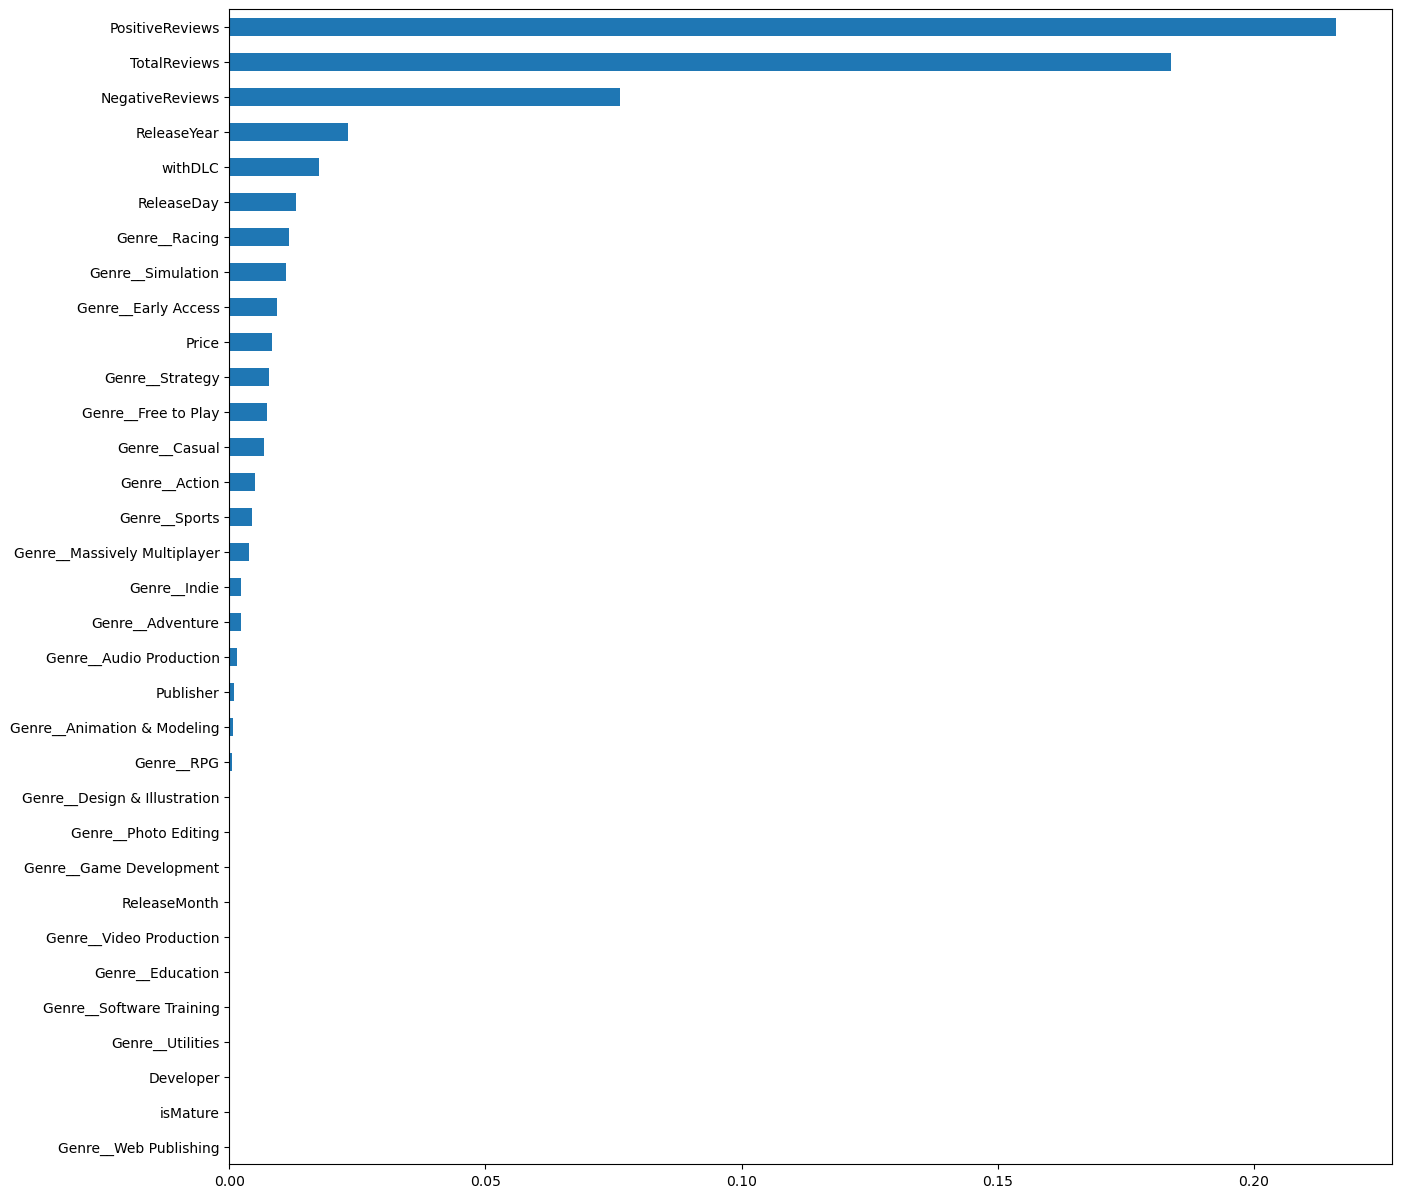

In [17]:
X = cleaned_df.drop(columns = 'Rating')
y = cleaned_df['Rating']

mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index = X.columns).sort_values(ascending = True)

plt.figure(figsize = (15, 15))
mi_scores.plot.barh()
plt.show()

#### Ta có thể thấy mặc dù cột '**Genre**' có sự ảnh hưởng đến '**Rating**' hay không thì tại vì sau khi one-hot encode nó cùng với các giá trị khác biệt rất cao, mỗi cột 'Genre_*' đại diện cho một giá trị đấy nên đã kéo thấp giá trị mutual information

Ta dùng PCA để giảm chiều các cột **'Genre_'**, sau đó xét lại mối quan hệ

In [18]:
# from sklearn.decomposition import PCA

# genre_cols = [col for col in X.columns if 'Genre_' in col]
# pca = PCA(n_components=1)
# X['Genre_pca'] = pca.fit_transform(X[genre_cols])
# mi_scores = mutual_info_regression(X[['Genre_pca']], y)
# mi_scores

Phải chăng ngày phát hành thật sự không ảnh hưởng gì đến Rating của game ta sẽ phân ra model dựa trên các features có bao gồm Release Date và model không dựa trên

#### Validation

In [19]:
def Cross_val_scores(model, X_val, y_val):
    scores = -1 * cross_val_score(model, X_val, y_val, cv = 5, scoring = 'neg_mean_squared_error')
    
    return np.sqrt(scores).mean()

In [20]:
models = [('Linear Regression', LinearRegression()), 
          ('Decision Tree', DecisionTreeRegressor()),
          ('Random Forest', RandomForestRegressor()),
          ('Gradient Boosting', GradientBoostingRegressor())]

##### Features chứa Release Date

In [21]:
X = cleaned_df.drop('Rating', axis = 1)
y = cleaned_df['Rating']

In [22]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, random_state = 42)

In [28]:
performances = {} # dict used to store cross_val_scores of each model to examine

for name, model in models:
    model.fit(X_train, y_train)
    scores = Cross_val_scores(model, X_val, y_val)
    performances[name] = scores
    

LinearRegression()
DecisionTreeRegressor()
RandomForestRegressor()
GradientBoostingRegressor()


In [30]:
performances

{'Linear Regression': 0.03391090749204589,
 'Decision Tree': 0.017892184527043834,
 'Random Forest': 0.01216839712442474,
 'Gradient Boosting': 0.01033453821714903}

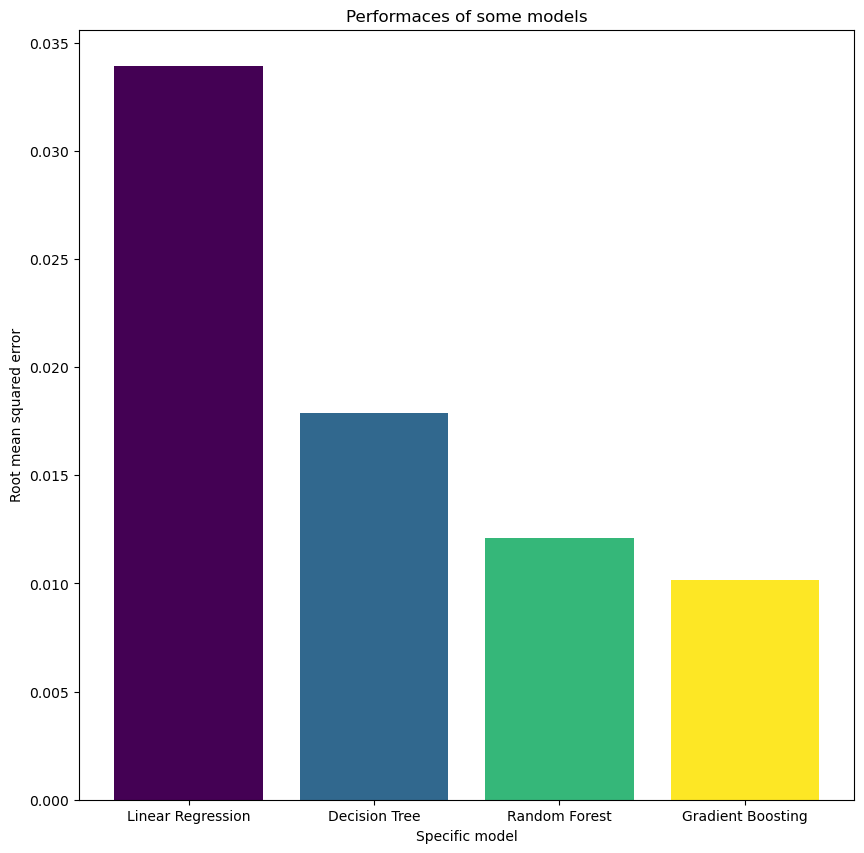

In [27]:
plt.figure(figsize = (10, 10))
colors = cm.viridis(np.linspace(0, 1, len(performances)))
plt.bar(performances.keys(), performances.values(), color = colors)
plt.xlabel('Specific model')
plt.ylabel('Root mean squared error')
plt.title('Performaces of some models')
plt.show()

#### Vậy ta chọn được mô hình cho kết quả tốt nhất là Gradient Boosting

##### TEST model on test set

In [32]:
best_model = GradientBoostingRegressor()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE on test set: {rmse_test}')

RMSE on test set: 0.006887037562349405
